In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm
from matplotlib.pyplot import figure
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
from scipy.special import expit # Numerically stable sigmoid function

from ipywidgets import interactive

import warnings
#suppress warnings
warnings.filterwarnings('ignore')

# Import data
# Main data
X = np.load('../data/processed/data_tensor_JJ.npz')

N = X['N']
M = X['M']
y = X['y']
z = X['z']
n_y = X['n_y']
n_z = X['n_z']
area = X['area']
wind = X['wind']
distance = X['distance']
sI1 = X['sI1']
sI2 = X['sI2'] 
tI1 = X['tI1']
tI2 = X['tI2']
s_i = X['s_i']
s_j = X['s_j']

# Data for the estimation of cone incidence vs leaf incidence
df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

# Data preprocessing
df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

# Data for the estimation of yield loss vs cone incidence (change in quantity metric)
df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

# Data for the estimation of cone color vs cone incidence (change in quality metric)
df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
#df_cone_color_cone_incidence = df_cone_color_cone_incidence[df_cone_color_cone_incidence['Year'] == 2009]
df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]


# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

# Load parameters
theta = np.load('../reports/parameters/theta_jun-jul_2014_SLSQP.npy', allow_pickle=True)

theta_may_jun = np.load('../reports/parameters/theta_may-jun_SLSQP_power.npy', allow_pickle=True)
theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_SLSQP_power.npy', allow_pickle=True)

In [2]:
year = [2017]
period = ['may-jun'] # inputs: 'may-jun', 'jun-jul'

for year in year:
    
    # Import data
    if year == 2014:
        X = np.load('../data/processed/data_2014.npz')
        N = X['N']
        
    elif year == 2015:
        X = np.load('../data/processed/data_2015.npz')
        N = X['N']
        
    elif year == 2016:
        X = np.load('../data/processed/data_2016.npz')
        N = X['N']
        
    elif year == 2017:
        X = np.load('../data/processed/data_2017.npz')
        N = X['N']

    dist = X['distance']
    tI1 = X['tI1'].reshape(N,1)
    tI2 = X['tI2'].reshape(N,1)
    sI2 = X['sI2'].reshape(N,1)
    
    y_apr = X['y_apr'].reshape(N,1)
    y_may = X['y_may'].reshape(N,1)
    y_jun = X['y_jun'].reshape(N,1)
    y_jul = X['y_jul'].reshape(N,1)

    n_apr = X['n_apr'].reshape(N,1)
    n_may = X['n_may'].reshape(N,1)
    n_jun = X['n_jun'].reshape(N,1)
    n_jul = X['n_jul'].reshape(N,1)

    a_apr = X['a_apr'].reshape(N,1)
    a_may = X['a_may'].reshape(N,1)
    a_jun = X['a_jun'].reshape(N,1)
    a_jul = X['a_jul'].reshape(N,1)

    w_apr = X['wind_apr']
    w_may = X['wind_may']
    w_jun = X['wind_jun']
    w_jul = X['wind_jul']

    sI1_apr = X['sI1_apr'].reshape(N,1)
    sI1_may = X['sI1_may'].reshape(N,1)
    sI1_jun = X['sI1_jun'].reshape(N,1)
    sI1_jul = X['sI1_jul'].reshape(N,1)

    s_apr = X['s_apr'].reshape(N,1)
    s_may = X['s_may'].reshape(N,1)
    s_jun = X['s_jun'].reshape(N,1)
    s_jul = X['s_jul'].reshape(N,1)


    # Function to normalize the data
    def norm(x):
        
        return (x - np.min(x)) / (np.max(x) - np.min(x))
    
    # Normalize the data
    # dist = norm(dist)
    
    # a_apr = norm(a_apr)
    # a_may = norm(a_may)
    # a_jun = norm(a_jun)
    # a_jul = norm(a_jul)
    
    
    def eta(period, y_lag, sprays):
        
        y_lag = y_lag
        
        if period == 'may-jun':
            theta = theta_may_jun
            #y_lag = y_may
            n_lag = n_may
            a_lag = a_may
            w_lag = w_may
            #sI1_lag = sI1_may
            #s_lag = sprays # need to fix this to be a conditional function
            s_lag = s_may

        elif period == 'jun-jul':
            theta = theta_jun_jul
            #y_lag = y_jun
            n_lag = n_jun
            a_lag = a_jun
            w_lag = w_jun
            #sI1_lag = sI1_jun
            #s_lag = predict_sprays(period, sprays)
            s_lag = s_jun
            
        beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
        
        beta1_array = np.full((N,1), beta1)
        beta2_array = np.full((N,1), beta2)
        
        auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
        auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)
        
        dispersal1 = []
        dispersal2 = []
        
        eta_1 = [] 
        
        for i in range(0, N):
            
            dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
            dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha1) * sI1_lag
            dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.power(1 + dist[:, i].reshape(N,1), -alpha2) * sI2
            dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
            dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])
            
            dispersal1.append(dispersal_component1_i)
            dispersal2.append(dispersal_component2_i)
        
        dispersal1 = np.array(dispersal1).reshape(N,1)
        dispersal2 = np.array(dispersal2).reshape(N,1)
        
        eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)
        
        eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
        eta_1.append(eta_1_i)
        eta_1 = np.array(eta_1).reshape(N,1)
        
        return eta, eta_1

# Probability Function

def prob(period, y_lag, sprays):
    
    etaa = eta(period, y_lag, sprays)
    
    p = expit(etaa[0])
    
    for i in range(0, N):
    
        if etaa[1][i] == 0.0:
            
            p[i] = 0.0    
    
    return p

## Plant Incidence vs Leaf Incidence

### Plant Incidence

In [4]:
plant_incidence = prob(theta)

### Leaf Incidence vs Plant Incidence

$$\text{leaf incidence} = 1-(1-p)^\frac{1}{n_D}$$

Where $p$ is the probability of disease, also known as the *plant incidence*.

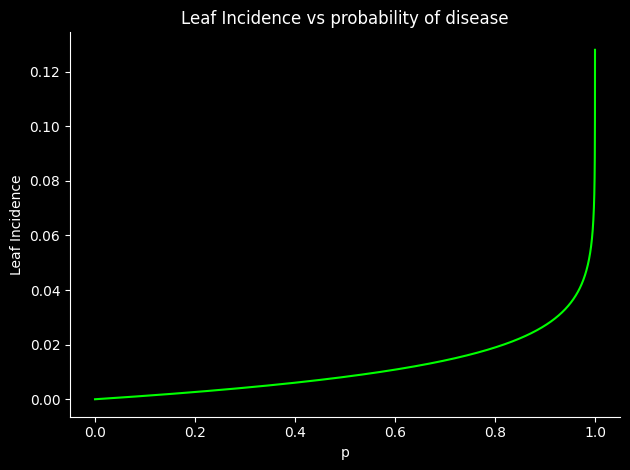

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def leaf_incidence(p, n_D):
    return 1 - (1 - (p - 0.00001))**(1 / n_D)

# Set the value of n_D
n_D = 100 / 1.19

# Create an array of values for p between 0 and 1
p_values = np.linspace(0, 1, 10000)

# Calculate the leaf incidence for each value of p
leaf_incidence_values = leaf_incidence(p_values, n_D)

# Set the dark theme
plt.style.use('dark_background')

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the function
ax.plot(p_values, leaf_incidence_values, color='lime')
ax.set_xlabel('p')
ax.set_ylabel('Leaf Incidence')
ax.set_title('Leaf Incidence vs probability of disease')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()

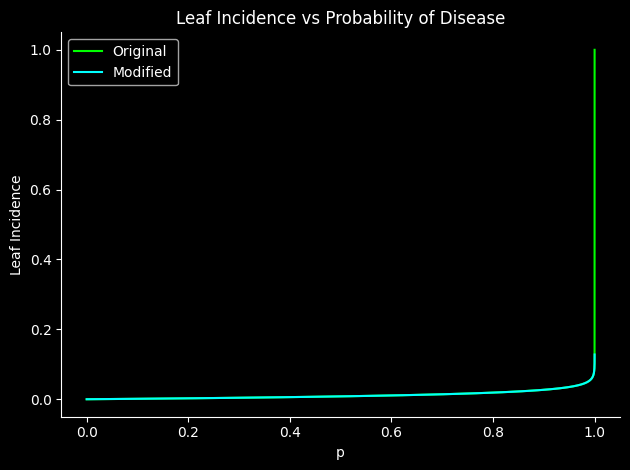

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def leaf_incidence(p, n_D):
    return 1 - (1 - p)**(1 / n_D)

def modified_leaf_incidence(p, n_D):
    return 1 - (1 - (p - 0.00001))**(1 / n_D)

# Set the value of n_D
n_D = 100 / 1.19

# Create an array of values for p between 0 and 1
p_values = np.linspace(0, 1, 10000)

# Calculate the leaf incidence for each value of p
leaf_incidence_values = leaf_incidence(p_values, n_D)
modified_leaf_incidence_values = modified_leaf_incidence(p_values, n_D)

# Set the dark theme
plt.style.use('dark_background')

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the functions
ax.plot(p_values, leaf_incidence_values, color='lime', label='Original')
ax.plot(p_values, modified_leaf_incidence_values, color='cyan', label='Modified')

ax.set_xlabel('p')
ax.set_ylabel('Leaf Incidence')
ax.set_title('Leaf Incidence vs Probability of Disease')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

### Cone Color vs Cone Incidence (Effect on Quality metric)

In [8]:
data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

# Linear regression

# adjust y-values to make intercept 0
adjusted_y = data_cone_color_cone_incidence[:, 1] - 10

# fit a line with intercept of 0
a3, b3 = np.polyfit(data_cone_color_cone_incidence[:, 0], adjusted_y, 1)

# when making predictions, add 10 back to the y-values

def cone_color_cone_incidence(cone_incidence):
    
    # intercept fixed at 10 since that's the highest cone color rating
    cone_color = a3 * cone_incidence + 10
    
    return cone_color

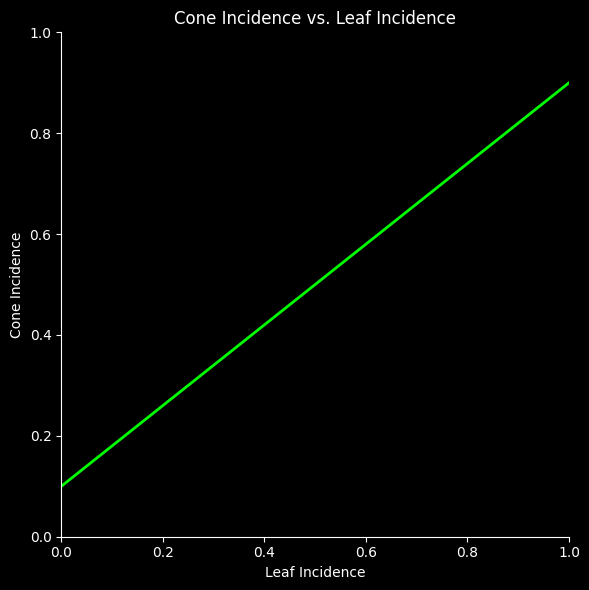

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Set the dark theme
plt.style.use('dark_background')

# Define a1 and b1 (replace with your actual values)
a1 = 0.8
b1 = 0.1

# Generate leaf_incidence values
leaf_incidence = np.linspace(0, 1, 100)

# Calculate cone_incidence values
cone_incidence = a1 * leaf_incidence + b1

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the function
ax.plot(leaf_incidence, cone_incidence, color='lime', linewidth=2)

# Set labels and title
ax.set_xlabel('Leaf Incidence')
ax.set_ylabel('Cone Incidence')
ax.set_title('Cone Incidence vs. Leaf Incidence')

# Set the limits of the axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust the plot layout
fig.tight_layout()

# Display the plot
plt.show()

Output when input is 0: 10.0


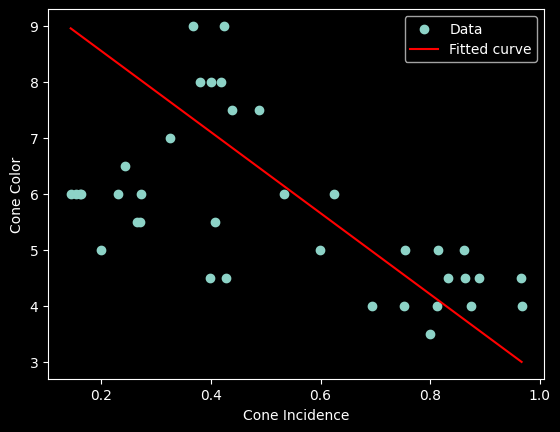

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

# Define the exponential decay function that passes through (0, 10)
def exp_decreasing(x, a3, b3):
    return 10 + a3 * (1 - np.exp(-b3 * x))

# Provide an initial guess for the parameters
initial_guess = [1, 1]

# Fit the exponential decay model to the data, with an increased max number of function evaluations
params, _ = curve_fit(exp_decreasing, data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], p0=initial_guess, maxfev=5000)

# Define the prediction function using the fitted parameters
def cone_color_cone_incidence(cone_incidence):
    return exp_decreasing(cone_incidence, *params)



# Verify that the output is 10 when the input is 0
print("Output when input is 0:", cone_color_cone_incidence(0))  # Should be 10

# Plotting the data and the fitted curve
plt.scatter(data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], label='Data')
x_values = np.linspace(min(data_cone_color_cone_incidence[:, 0]), max(data_cone_color_cone_incidence[:, 0]), 100)
y_values = [cone_color_cone_incidence(x) for x in x_values]
plt.plot(x_values, y_values, label='Fitted curve', color='red')
# Set the dark theme
plt.style.use('dark_background')
plt.xlabel('Cone Incidence')
plt.ylabel('Cone Color')
plt.legend()
plt.show()


In [54]:
a3

42534.750765091434

In [18]:
# Plot cone color vs cone incidence
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_cone_color_cone_incidence[:, 0], y=data_cone_color_cone_incidence[:, 1],
                    mode='markers',
                    name='Data'))

fig.add_trace(go.Scatter(x=data_cone_color_cone_incidence[:, 0], y=cone_color_cone_incidence(data_cone_color_cone_incidence[:, 0]),
                    mode='lines',
                    name='Linear regression'))

fig.update_layout(
    title="Cone color vs cone incidence",
    xaxis_title="Cone incidence",
    yaxis_title="Cone color",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

### Yield Loss vs Plant Incidence (Effect on Quantity metric)

In [22]:
# Data
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()

# Linear regressions
a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)
a2, b2 = np.polyfit(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 1)


# YIELD LOSS VS. PLANT INCIDENCE


# Function to estimate yield loss given plant incidence (probability of disease in plants)
def yield_loss_plant_incidence(plant_incidence, n=100, D=1.19):
    
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D 
    
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    yield_loss = a2 * cone_incidence
    
    return yield_loss


x = np.linspace(0, 1, 1000)

px.line(x=x, y=yield_loss_plant_incidence(x), labels={"x": "Plant Incidence", "y": "Yield Loss"}, width=500, height=500)

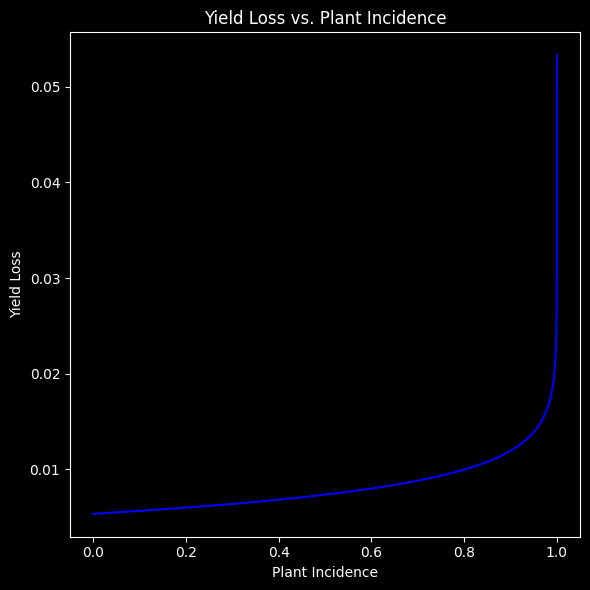

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Data
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()

# Linear regressions
a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)
a2, b2 = np.polyfit(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 1)

# YIELD LOSS VS. PLANT INCIDENCE
# Function to estimate yield loss given plant incidence (probability of disease in plants)
def yield_loss_plant_incidence(plant_incidence, n=100, D=1.19):
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D
    leaf_incidence = 1 - (1 - (plant_incidence - 0.00000001)) ** (1 / n_D)
    cone_incidence = a1 * leaf_incidence + b1
    yield_loss = a2 * cone_incidence
    return yield_loss

x = np.linspace(0, 1, 10000)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the yield loss vs. plant incidence
ax.plot(x, yield_loss_plant_incidence(x), color='blue')

# Set labels and title
ax.set_xlabel('Plant Incidence')
ax.set_ylabel('Yield Loss')
ax.set_title('Yield Loss vs. Plant Incidence')

# Adjust the plot layout
fig.tight_layout()

# Display the plot
plt.show()

In [32]:
yield_loss_plant_incidence(1)

0.24884201106856502

In [31]:
yield_loss_plant_incidence(1-0.999999999999)

0.07359419065857914

In [6]:
1-1e-12

0.999999999999

In [3]:
decimal_form = 1e-10
print(decimal_form)

1e-10


In [15]:
1-1/400

0.9975

In [31]:
def f(n, D):
   
    plt.figure(2)
    x = np.linspace(0, 1, 1000)
    plt.plot(x, yield_loss_plant_incidence(x, n, D))
    plt.ylim(0, 0.3)
    plt.ylabel("Yield Loss")
    plt.xlabel("Plant Incidence")
    plt.show()
    
interactive_plot = interactive(f, n=(1, 100), D=(1.0, 2.0, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(IntSlider(value=50, description='n', min=1), FloatSlider(value=1.5, description='D', max…

## Yield Loss estimation using the model

In [10]:
plt.scatter(plant_incidence, yield_loss_plant_incidence(plant_incidence, n=10, D=1.19))
plt.ylabel("Yield Loss")
plt.xlabel("Plant Incidence / Probability of Disease")
plt.show()

NameError: name 'plant_incidence' is not defined

In [11]:
def f(n):
   
    plt.scatter(plant_incidence, yield_loss_plant_incidence(plant_incidence, n))
    plt.ylabel("Yield Loss")
    plt.xlabel("Plant Incidence / Probability of Disease")
    plt.ylim(0, 0.3)
    plt.show()
    
interactive_plot = interactive(f, n=(1, 100, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=50, description='n', min=1), Output(layout=Layout(height='350px'))), _do…

# Dash app

In [ ]:
import numpy as np

import plotly.graph_objects as go
import pandas as pd


from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px


# Data for the estimation of cone incidence vs leaf incidence
df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

# Data preprocessing
df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

# Data for the estimation of yield loss vs cone incidence (change in quantity metric)
df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

# Data for the estimation of cone color vs cone incidence (change in quality metric)
df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_cone_color_cone_incidence = df_cone_color_cone_incidence[df_cone_color_cone_incidence['Year'] == 2009]
df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]


# Data
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()

# Linear regressions
a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)
a2, b2 = np.polyfit(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 1)


# YIELD LOSS VS. PLANT INCIDENCE

def yield_loss_plant_incidence(plant_incidence, n=10, D=1.19):
    
    n_D = n / D
    
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    yield_loss = a2 * cone_incidence
    
    return yield_loss


app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id='graph-with-slider'),
    dcc.Slider(
        1,
        20,
        step=1,
        value=10,
        id='my-slider'
    )
], style={'width': '50%', 'height': '100%'})


@app.callback(
    Output('graph-with-slider', 'figure'),
    Input('my-slider', 'value'))
def update_figure(num_leaves):

    x = np.linspace(0, 1, 1000)
    
    fig = px.line(x=x, y=yield_loss_plant_incidence(x, num_leaves), labels={"x": "Plant Incidence", "y": "Yield Loss"}, width=500, height=500)

    fig.update_layout(transition_duration=500)

    return fig

# Run app and display result inline in the notebook
app.run_server(mode='inline')

## Expected Revenue Given Demand

### Revenue

In [12]:
# Function to estimate cone incidence given plant incidence (probability of disease in plants)
def cone_incidence_plant_incidence(plant_incidence, n=10, D=1.19):
    
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D 
    
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    return cone_incidence

# Function to estimate adjusted price given plant incidence (probability of disease in plants)
def adjusted_price_high(plant_incidence, initial_price=6):
    
    cone_incidence = cone_incidence_plant_incidence(plant_incidence)
    cone_color = cone_color_cone_incidence(cone_incidence)
    adjusted_price = initial_price * sigmoid(theta_high[0] + theta_high[1] * cone_color)
    
    return adjusted_price

def adjusted_price_mod(plant_incidence, initial_price=4.25):
    
    cone_incidence = cone_incidence_plant_incidence(plant_incidence)
    cone_color = cone_color_cone_incidence(cone_incidence)
    adjusted_price = initial_price * sigmoid(theta_moderate[0] + theta_moderate[1] * cone_color)
    
    return adjusted_price

def adjusted_price_low(plant_incidence, initial_price=2.5):
    
    cone_incidence = cone_incidence_plant_incidence(plant_incidence)
    cone_color = cone_color_cone_incidence(cone_incidence)
    adjusted_price = initial_price * sigmoid(theta_low[0] + theta_low[1] * cone_color)
    
    return adjusted_price

# Function to estimate yield loss given plant incidence (probability of disease in plants)
def adjusted_yield(plant_incidence, initial_yield=2038):
    
    adjusted_yield_loss = initial_yield * (1 - yield_loss_plant_incidence(plant_incidence))
    
    return adjusted_yield_loss

# Function to estimate adjusted revenue given plant incidence (probability of disease in plants)
def revenue_change_high(plant_incidence, initial_price=6, initial_yield=2038):
    
    revenue = initial_price * initial_yield
    adjusted_revenue = adjusted_price_high(plant_incidence) * adjusted_yield(plant_incidence)
    revenue_change = (adjusted_revenue - revenue) / revenue
    
    return revenue_change

# Function to estimate adjusted revenue given plant incidence (probability of disease in plants)
def revenue_change_mod(plant_incidence, initial_price=4.25, initial_yield=2038):
    
    revenue = initial_price * initial_yield
    adjusted_revenue = adjusted_price_mod(plant_incidence) * adjusted_yield(plant_incidence)
    revenue_change = (adjusted_revenue - revenue) / revenue
    
    return revenue_change

# Function to estimate adjusted revenue given plant incidence (probability of disease in plants)
def revenue_change_low(plant_incidence, initial_price=2.5, initial_yield=2038):
    
    revenue = initial_price * initial_yield
    adjusted_revenue = adjusted_price_low(plant_incidence) * adjusted_yield(plant_incidence)
    revenue_change = (adjusted_revenue - revenue) / revenue
    
    return revenue_change

In [13]:
plt.figure(2)
x = np.linspace(0.95, 0.99, 1000)

plt.plot(x, revenue_change_high(x), color='r', label='high demand')
plt.plot(x, revenue_change_mod(x), color='b', label='moderate demand')
plt.plot(x, revenue_change_low(x), color='g', label='low demand')

plt.ylabel("proportion revenue change")
plt.xlabel("Probability of disease")
plt.title("Revenue change given probability of disease")
plt.legend()
plt.show()

NameError: name 'sigmoid' is not defined

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(2)
x = np.linspace(0.95, 0.99, 1000)

plt.plot(x, revenue_change_high(x), color='r', label='high demand')
plt.plot(x, revenue_change_mod(x), color='b', label='moderate demand')
plt.plot(x, revenue_change_low(x), color='g', label='low demand')

plt.ylabel("proportion revenue change")
plt.xlabel("Probability of disease")
plt.title("Revenue change given probability of disease")
plt.legend()
plt.show()

NameError: name 'sigmoid' is not defined

<Figure size 640x480 with 0 Axes>

### Actual revenue change estimation

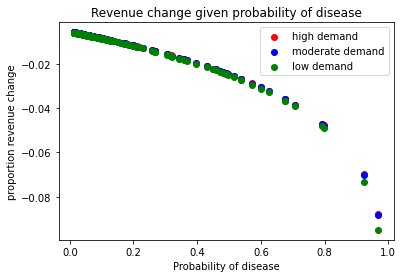

In [265]:
plt.figure(2)
plant_incidence

plt.scatter(plant_incidence, revenue_change_high(plant_incidence), color='r', label='high demand')
plt.scatter(plant_incidence, revenue_change_mod(plant_incidence), color='b', label='moderate demand')
plt.scatter(plant_incidence, revenue_change_low(plant_incidence), color='g', label='low demand')

plt.ylabel("proportion revenue change")
plt.xlabel("Probability of disease")
plt.title("Revenue change given probability of disease")
plt.legend()
plt.show()